Importing the dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math
import yfinance as yf
from datetime import date, timedelta

Data Collection from yFinanace

In [2]:
maruti_ticker = yf.Ticker("MARUTI.NS")
df = maruti_ticker.history(period="1y")

# Save the data to CSV
df.to_csv('MARUTI.csv')

# Display the first few rows
print(df.head())

                                   Open          High           Low  \
Date                                                                  
2024-06-18 00:00:00+05:30  12757.897797  12759.482439  12424.694428   
2024-06-19 00:00:00+05:30  12492.008743  12506.868388  12085.845096   
2024-06-20 00:00:00+05:30  12131.414434  12190.357694  12021.453059   
2024-06-21 00:00:00+05:30  12105.657951  12250.539496  11970.435176   
2024-06-24 00:00:00+05:30  12067.022460  12174.011905  11928.332440   

                                  Close  Volume  Dividends  Stock Splits  
Date                                                                      
2024-06-18 00:00:00+05:30  12443.417969  823306        0.0           0.0  
2024-06-19 00:00:00+05:30  12127.550781  694871        0.0           0.0  
2024-06-20 00:00:00+05:30  12035.817383  907751        0.0           0.0  
2024-06-21 00:00:00+05:30  12087.331055  947800        0.0           0.0  
2024-06-24 00:00:00+05:30  12069.400391  550862     

In [3]:
# Data Preparation
# Reset index to get a clean dataframe with 'Close' column
df1 = df.reset_index()['Close']
print(df1.head())

0    12443.417969
1    12127.550781
2    12035.817383
3    12087.331055
4    12069.400391
Name: Close, dtype: float64


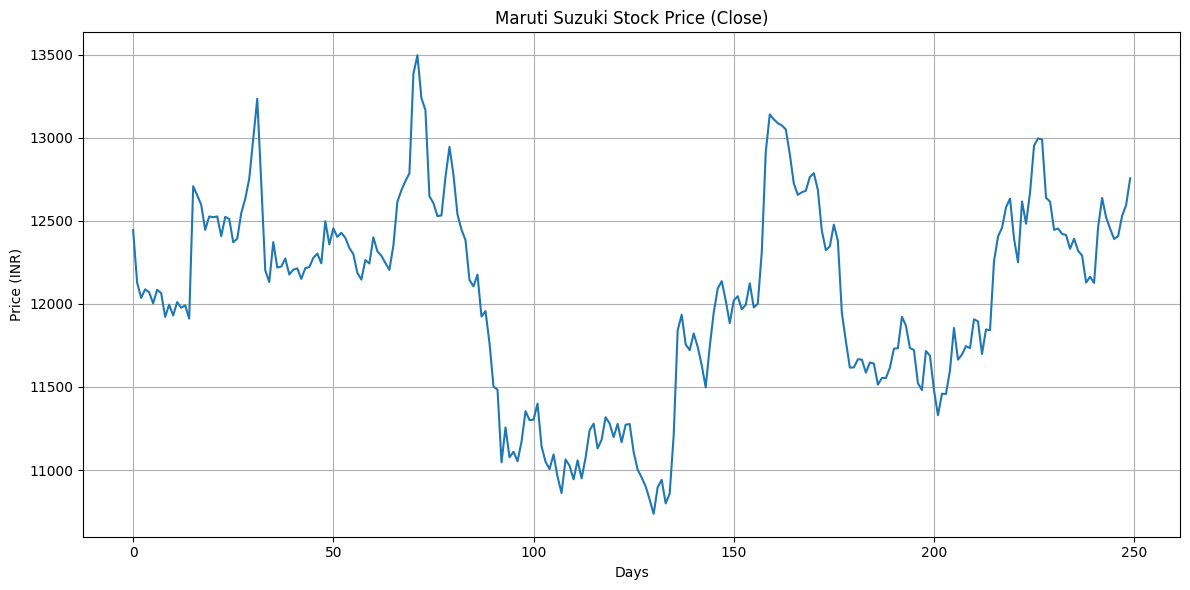

In [4]:
# Data Visualization
# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(df1)
plt.title('Maruti Suzuki Stock Price (Close)')
plt.xlabel('Days')
plt.ylabel('Price (INR)')
plt.grid(True)
plt.tight_layout()
plt.show()

Data Preprocessing

In [5]:
# Apply MinMax scaler to normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
print(f"Shape of normalized data: {df1.shape}")

Shape of normalized data: (250, 1)


Splitting dataset between Train and Test

In [6]:
# Split the data into training and testing sets
training_size = int(len(df1) * 0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size, :], df1[training_size:len(df1), :]
print(f"Training size: {training_size}, Test size: {test_size}")

Training size: 162, Test size: 88


In [7]:
# Create dataset with time steps
# Function to create dataset with time steps
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Define time step (reduced from 100 to 30 due to limited data)
time_step = 30
print(f"Time step: {time_step}")

# Create datasets with time steps
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Time step: 30
X_train shape: (131, 30), y_train shape: (131,)
X_test shape: (57, 30), y_test shape: (57,)


Creating and training the LSTM Model

In [8]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(f"Reshaped X_train: {X_train.shape}, Reshaped X_test: {X_test.shape}")

Reshaped X_train: (131, 30, 1), Reshaped X_test: (57, 30, 1)


In [10]:
# Create the Stacked LSTM model
from tensorflow.keras.layers import Input

model = Sequential()
model.add(Input(shape=(time_step, 1)))  # Explicit input layer
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=100, batch_size=64, verbose=1)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 411ms/step - loss: 0.2466 - val_loss: 0.1573
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1097 - val_loss: 0.0304
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0382 - val_loss: 0.0315
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0672 - val_loss: 0.0176
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0328 - val_loss: 0.0374
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0416 - val_loss: 0.0413
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0403 - val_loss: 0.0280
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0347 - val_loss: 0.0160
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0297 - val_loss: 0.0151
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0389 - val_loss: 0.0148
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0357 - val_loss: 0.0140
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0318 - val_l

Making Predictions

In [12]:
# Predict values
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Calculating RMSE

In [13]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

# Train data RMSE
train_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train.reshape(-1, 1)),
                                         train_predict))
print(f"Train RMSE: {train_rmse}")

# Test data RMSE
test_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)),
                                        test_predict))
print(f"Test RMSE: {test_rmse}")

Train RMSE: 333.590934534062
Test RMSE: 263.24961016566016


Plotting Results

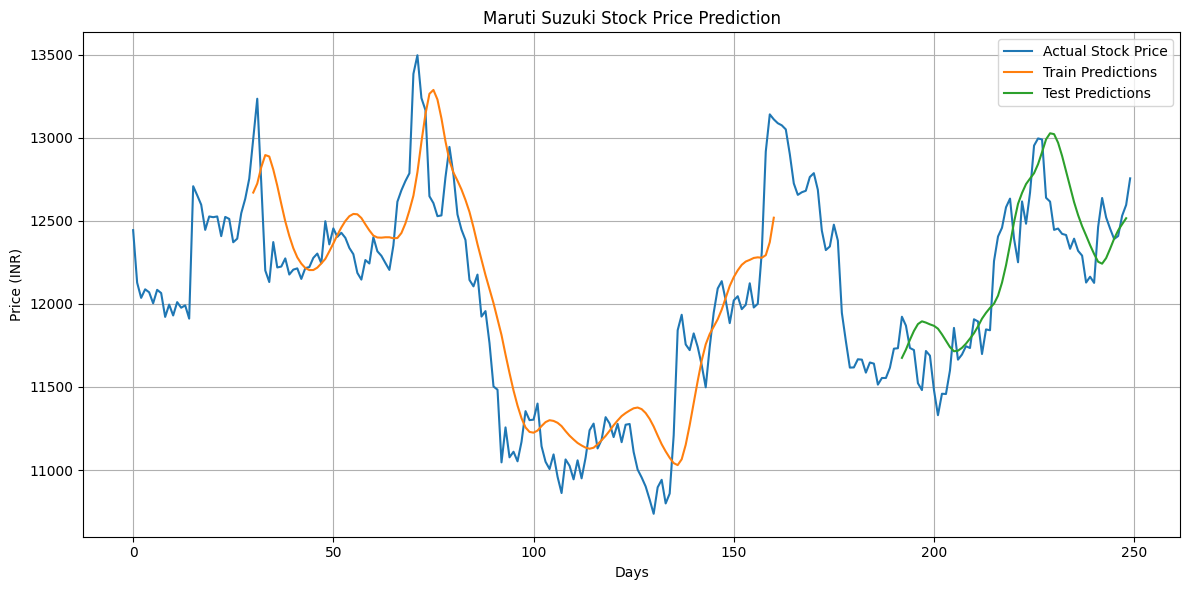

In [14]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(df1)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.title('Maruti Suzuki Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Predicting Future Prices

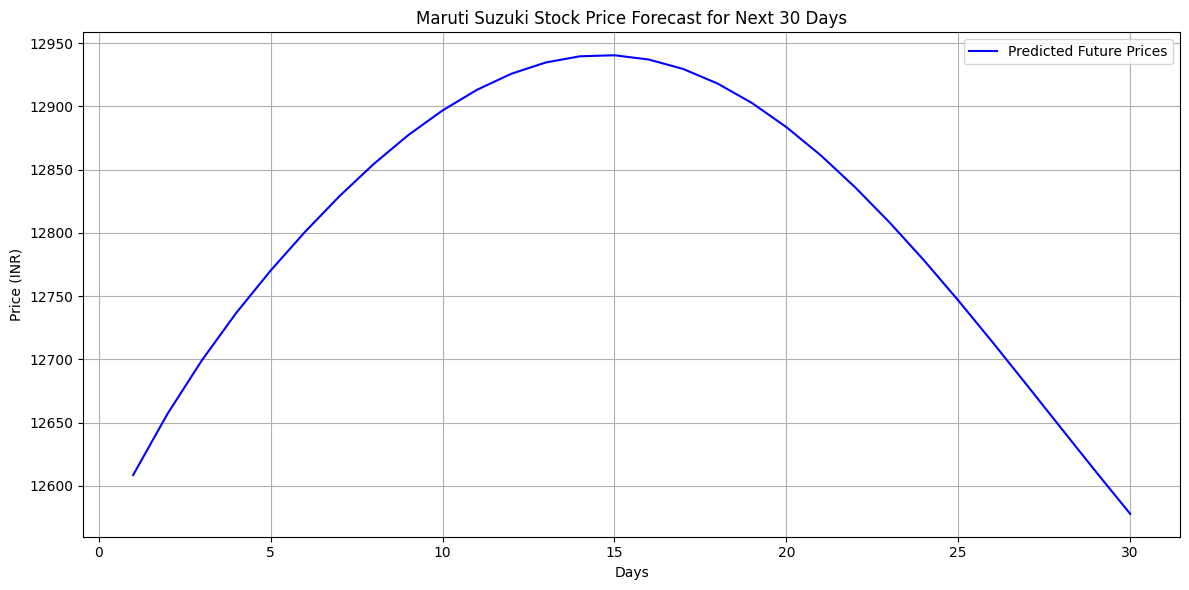


Predicted prices for next 30 days:
Day 1: ₹12608.47
Day 2: ₹12656.93
Day 3: ₹12699.22
Day 4: ₹12736.73
Day 5: ₹12770.19
Day 6: ₹12800.80
Day 7: ₹12828.96
Day 8: ₹12854.49
Day 9: ₹12877.24
Day 10: ₹12896.78
Day 11: ₹12913.09
Day 12: ₹12925.77
Day 13: ₹12934.69
Day 14: ₹12939.61
Day 15: ₹12940.41
Day 16: ₹12937.03
Day 17: ₹12929.57
Day 18: ₹12918.04
Day 19: ₹12902.67
Day 20: ₹12883.62
Day 21: ₹12861.32
Day 22: ₹12836.03
Day 23: ₹12808.29
Day 24: ₹12778.37
Day 25: ₹12746.58
Day 26: ₹12713.47
Day 27: ₹12679.54
Day 28: ₹12645.31
Day 29: ₹12611.29
Day 30: ₹12577.87


In [15]:
# Demonstrate prediction for next 30 days
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = time_step
i = 0

while(i < 30):  # Predict next 30 days
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Plot the future predictions
future_days = np.arange(1, 31)
plt.figure(figsize=(12, 6))
plt.plot(future_days, scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)),
         'b-', label='Predicted Future Prices')
plt.title('Maruti Suzuki Stock Price Forecast for Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the predicted values
print("\nPredicted prices for next 30 days:")
predicted_prices = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
for i, price in enumerate(predicted_prices):
    print(f"Day {i+1}: ₹{price[0]:.2f}")